<a href="https://colab.research.google.com/github/stevengregori92/RNN-Intro/blob/main/RNN_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'jcopdl<2.0'
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#Import Dataset

In [4]:
!unzip /content/dataa.zip

Archive:  /content/dataa.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
df = pd.read_csv('data/daily_min_temp.csv', parse_dates=['Date'], index_col = 'Date')
df.head()

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

In [6]:
df = df.resample('W').mean()

<Axes: xlabel='Date'>

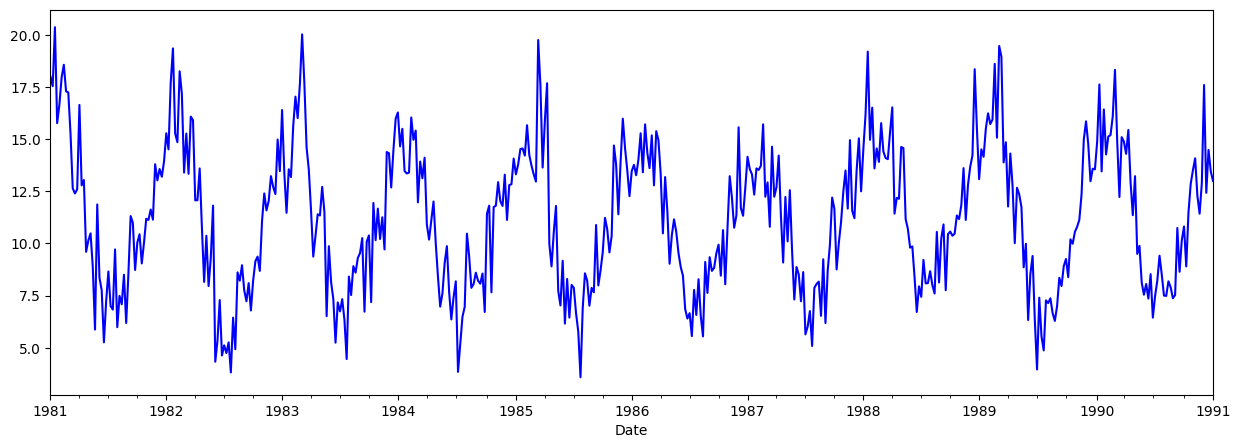

In [7]:
df.Temp.plot(figsize=(15,5), color = 'b')

#Dataset Splitting

In [8]:
ts_train, ts_test = train_test_split(df, test_size=.2, shuffle = False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

#Dataset & Dataloader

In [9]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [10]:
seq_len = 16
bs=8

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp',seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (26, 16, 1)
Note: last 1 data excluded

(N, S, F): (6, 16, 1)
Note: last 8 data excluded



#Arsitektur & Config

In [11]:
from jcopdl.layers import linear_block

In [12]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x, hidden):
    x, hidden = self.rnn(x, hidden)
    x = self.fc(x)
    return x, hidden

In [13]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout':  0,
    'seq_len': train_set.n_seq
})

#Training -> MCOC

In [14]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/rnn')

#Training

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device) # corrected line
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        
    cost = cost/len(dataset)
    return cost

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 129.0721 | Test_cost  = 119.4479 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 108.9181 | Test_cost  = 102.2399 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 93.2305 | Test_cost  = 88.7554 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 80.8753 | Test_cost  = 78.2132 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 71.3228 | Test_cost  = 70.2735 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 64.1538 | Test_cost  = 64.2236 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 58.5969 | Test_cost  = 59.2474 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 53.9502 | Test_cost  = 54.9480 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 49.9248 | Test_cost  = 51.1686 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 46.3634 | Test_cost  = 47.7547 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 43.1338 | Test_cost  = 44.6235 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 40.1705 | Test_cost  = 41.7374 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 37.4424 | Test_cost  = 39.0755 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 34.9308 | Test_cost  = 36.6228 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 32.6217 | Test_cost  = 34.3667 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 30.5026 | Test_cost  = 32.2951 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 28.5616 | Test_cost  = 30.3964 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 26.7873 | Test_cost  = 28.6595 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 25.1686 | Test_cost  = 27.0735 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 23.6949 | Test_cost  = 25.6281 | 


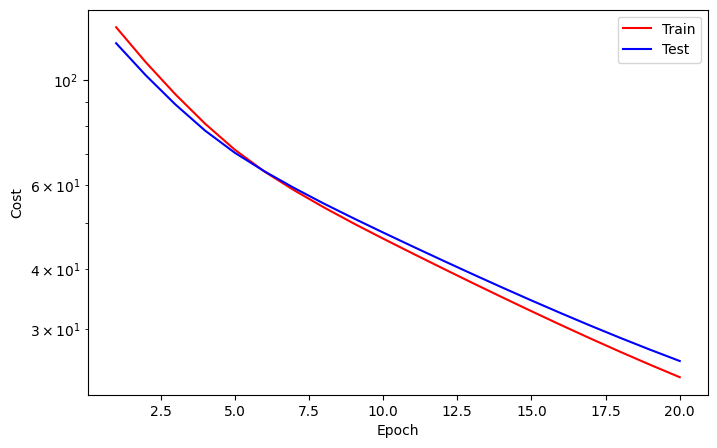

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 22.3559 | Test_cost  = 24.3132 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 21.1419 | Test_cost  = 23.1193 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 20.0434 | Test_cost  = 22.0374 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 19.0517 | Test_cost  = 21.0588 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 18.1584 | Test_cost  = 20.1755 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 17.3554 | Test_cost  = 19.3796 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 16.6353 | Test_cost  = 18.6641 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 15.9910 | Test_cost  = 18.0219 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 15.4158 | Test_cost  = 17.4468 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 14.9035 | Test_cost  = 16.9328 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 14.4483 | Test_cost  = 16.4742 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 14.0448 | Test_cost  = 16.0658 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 13.6880 | Test_cost  = 15.7028 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 13.3731 | Test_cost  = 15.3807 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 13.0959 | Test_cost  = 15.0955 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 12.8524 | Test_cost  = 14.8433 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 12.6390 | Test_cost  = 14.6206 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 12.4524 | Test_cost  = 14.4243 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 12.2896 | Test_cost  = 14.2515 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 12.1477 | Test_cost  = 14.0996 | 


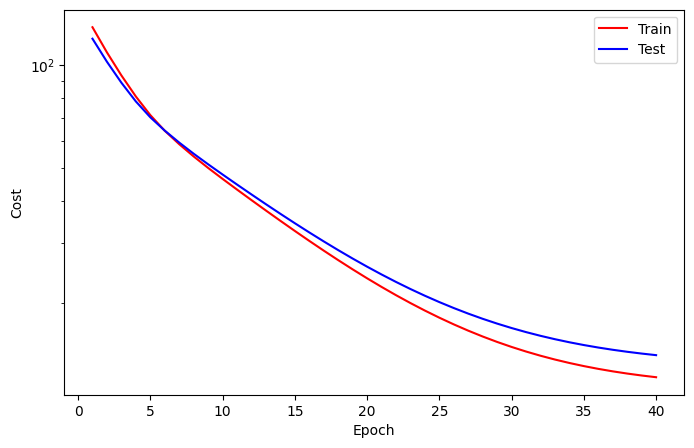

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 12.0245 | Test_cost  = 13.9662 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 11.9176 | Test_cost  = 13.8492 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 11.8250 | Test_cost  = 13.7467 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 11.7449 | Test_cost  = 13.6569 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 11.6758 | Test_cost  = 13.5783 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 11.6162 | Test_cost  = 13.5096 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 11.5649 | Test_cost  = 13.4495 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 11.5208 | Test_cost  = 13.3970 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 11.4829 | Test_cost  = 13.3511 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 11.4504 | Test_cost  = 13.3109 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 11.4224 | Test_cost  = 13.2758 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 11.3985 | Test_cost  = 13.2451 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 11.3779 | Test_cost  = 13.2183 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 11.3603 | Test_cost  = 13.1947 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 11.3451 | Test_cost  = 13.1741 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 11.3321 | Test_cost  = 13.1561 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 11.3209 | Test_cost  = 13.1402 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 11.3113 | Test_cost  = 13.1263 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 11.3029 | Test_cost  = 13.1140 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 11.2958 | Test_cost  = 13.1032 | 


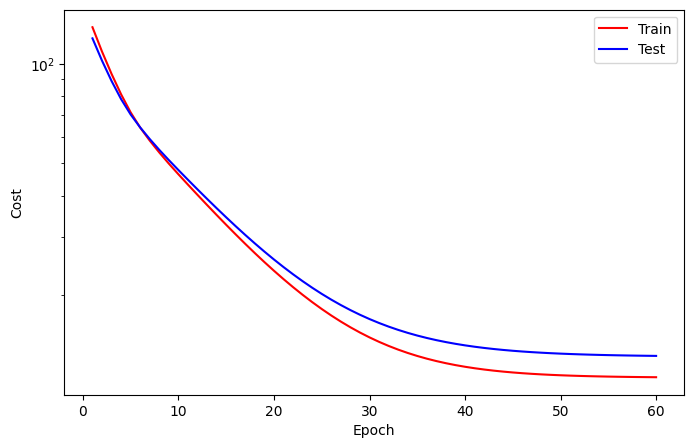

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 11.2895 | Test_cost  = 13.0937 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 11.2841 | Test_cost  = 13.0853 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 11.2794 | Test_cost  = 13.0779 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 11.2753 | Test_cost  = 13.0714 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 11.2717 | Test_cost  = 13.0656 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 11.2685 | Test_cost  = 13.0604 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 11.2657 | Test_cost  = 13.0558 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 11.2632 | Test_cost  = 13.0517 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 11.2610 | Test_cost  = 13.0481 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 11.2590 | Test_cost  = 13.0449 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 11.2573 | Test_cost  = 13.0419 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 11.2556 | Test_cost  = 13.0393 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 11.2542 | Test_cost  = 13.0370 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 11.2528 | Test_cost  = 13.0349 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

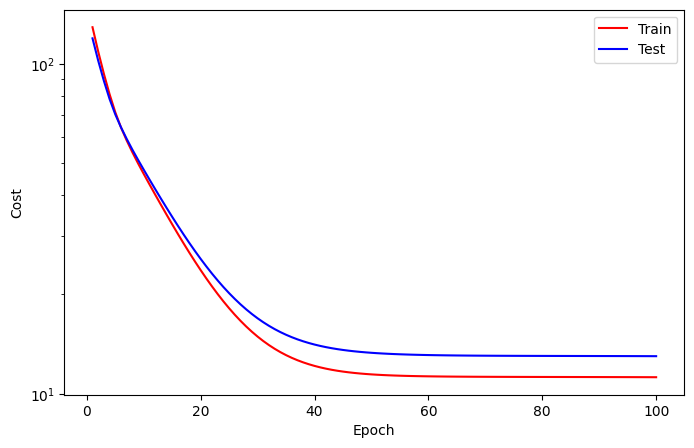

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 11.2238 | Test_cost  = 12.9980 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 11.2214 | Test_cost  = 12.9949 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 11.2185 | Test_cost  = 12.9912 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 11.2149 | Test_cost  = 12.9864 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 11.2103 | Test_cost  = 12.9800 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 11.2039 | Test_cost  = 12.9704 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 11.1940 | Test_cost  = 12.9539 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 11.1761 | Test_cost  = 12.9183 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 11.1334 | Test_cost  = 12.8207 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 11.0493 | Test_cost  = 12.8141 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 11.0384 | Test_cost  = 12.7175 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 10.9311 | Test_cost  = 12.5232 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 6.8665 | Test_cost  = 7.4610 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 6.7139 | Test_cost  = 7.2516 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 6.5725 | Test_cost  = 7.0608 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 6.4436 | Test_cost  = 6.8897 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 6.3231 | Test_cost  = 6.7346 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 6.2058 | Test_cost  = 6.5920 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 6.0988 | Test_cost  = 6.4583 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 5.9957 | Test_cost  = 6.3323 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 5.9031 | Test_cost  = 6.2136 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 5.8133 | Test_cost  = 6.1025 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 5.7312 | Test_cost  = 5.9976 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 5.6495 | Test_cost  = 5.8985 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 5.5726 | Test_cost  = 5.8030 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 4.0401 | Test_cost  = 4.1981 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 3.9927 | Test_cost  = 4.1576 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 3.9493 | Test_cost  = 4.1180 | 


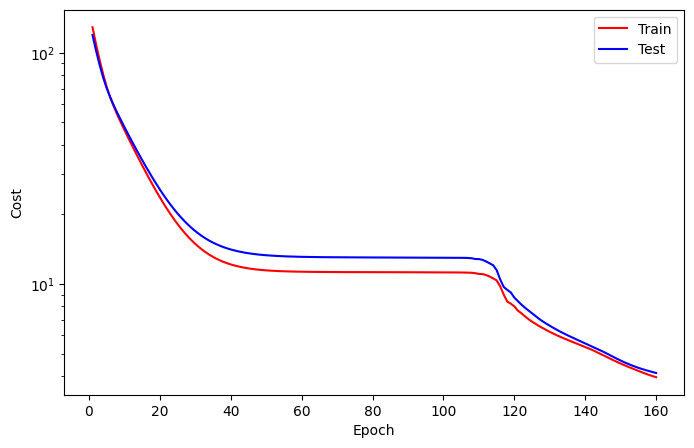

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 3.9096 | Test_cost  = 4.0781 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 3.8731 | Test_cost  = 4.0373 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 3.8396 | Test_cost  = 3.9966 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 3.8091 | Test_cost  = 3.9565 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 3.7811 | Test_cost  = 3.9169 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 3.7551 | Test_cost  = 3.8781 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 3.7307 | Test_cost  = 3.8415 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 3.7083 | Test_cost  = 3.8070 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 3.6873 | Test_cost  = 3.7740 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

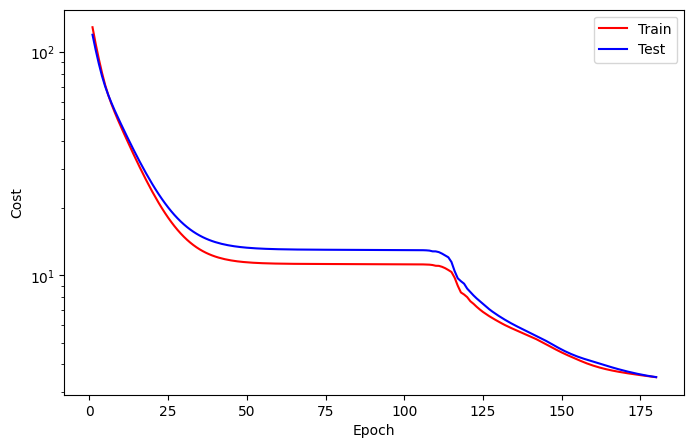

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 3.4898 | Test_cost  = 3.4940 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 3.4760 | Test_cost  = 3.4804 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 3.4625 | Test_cost  = 3.4679 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 3.4493 | Test_cost  = 3.4567 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 3.4363 | Test_cost  = 3.4469 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 3.4236 | Test_cost  = 3.4386 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 3.4110 | Test_cost  = 3.4318 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 3.3986 | Test_cost  = 3.4263 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 3.3864 | Test_cost  = 3.4220 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 3.3744 | Test_cost  = 3.4184 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 3.3628 | Test_cost  = 3.4151 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 3.3515 | Test_cost  = 3.4116 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

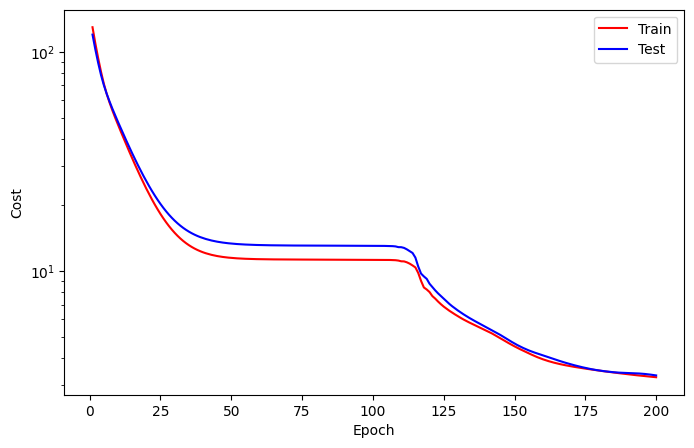

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 3.2618 | Test_cost  = 3.3183 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 3.2531 | Test_cost  = 3.3032 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 3.2445 | Test_cost  = 3.2885 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 3.2362 | Test_cost  = 3.2747 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 3.2280 | Test_cost  = 3.2616 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 3.2200 | Test_cost  = 3.2496 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 3.2122 | Test_cost  = 3.2387 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 3.2046 | Test_cost  = 3.2285 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 3.1970 | Test_cost  = 3.2190 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 3.1896 | Test_cost  = 3.2101 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 3.1824 | Test_cost  = 3.2014 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 3.1753 | Test_cost  = 3.1928 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

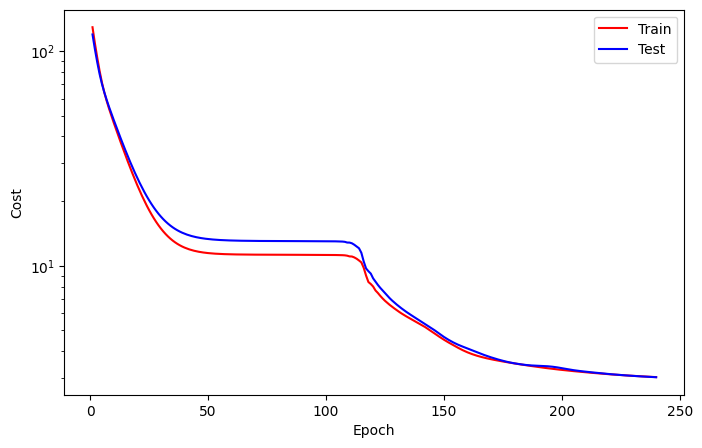

Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 3.0239 | Test_cost  = 3.0203 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 3.0202 | Test_cost  = 3.0168 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 3.0167 | Test_cost  = 3.0137 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 3.0131 | Test_cost  = 3.0103 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 3.0096 | Test_cost  = 3.0074 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 3.0062 | Test_cost  = 3.0045 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 3.0027 | Test_cost  = 3.0016 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 2.9995 | Test_cost  = 2.9992 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 2.9961 | Test_cost  = 2.9963 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 2.9929 | Test_cost  = 2.9942 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 2.9897 | Test_cost  = 2.9919 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 2.9864 | Test_cost  = 2.9894 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 2.9068 | Test_cost  = 2.9258 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 2.9095 | Test_cost  = 2.9964 | 


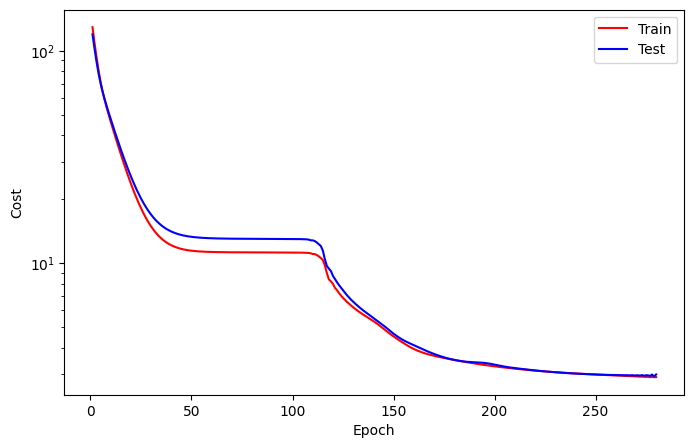

==> EarlyStop patience =  1 | Best test_cost: 2.9258


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 2.9201 | Test_cost  = 2.9428 | 
==> EarlyStop patience =  2 | Best test_cost: 2.9258


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 2.8907 | Test_cost  = 2.9508 | 
==> EarlyStop patience =  3 | Best test_cost: 2.9258


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 2.9209 | Test_cost  = 3.0171 | 
==> EarlyStop patience =  4 | Best test_cost: 2.9258


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 2.8898 | Test_cost  = 2.8915 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 2.9153 | Test_cost  = 3.0620 | 
==> EarlyStop patience =  1 | Best test_cost: 2.8915


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 2.9371 | Test_cost  = 2.8379 | 


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 2.9619 | Test_cost  = 3.0356 | 
==> EarlyStop patience =  1 | Best test_cost: 2.8379


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 2.9825 | Test_cost  = 2.8762 | 
==> EarlyStop patience =  2 | Best test_cost: 2.8379


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 2.9305 | Test_cost  = 3.0417 | 
==> EarlyStop patience =  3 | Best test_cost: 2.8379


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 2.9472 | Test_cost  = 2.8726 | 
==> EarlyStop patience =  4 | Best test_cost: 2.8379


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 2.9409 | Test_cost  = 3.1103 | 
==> EarlyStop patience =  5 | Best test_cost: 2.8379
==> Execute Early Stopping at epoch: 291 | Best test_cost: 2.8379
==> Best model is saved at model/rnn


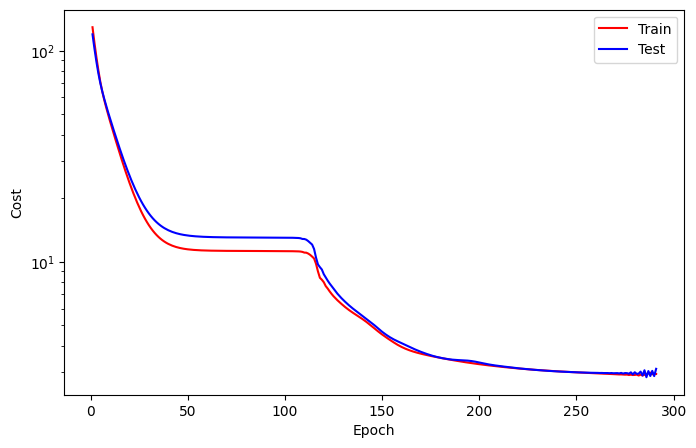

In [16]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

#Forecast

In [17]:
from utils import data4pred, pred4pred

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

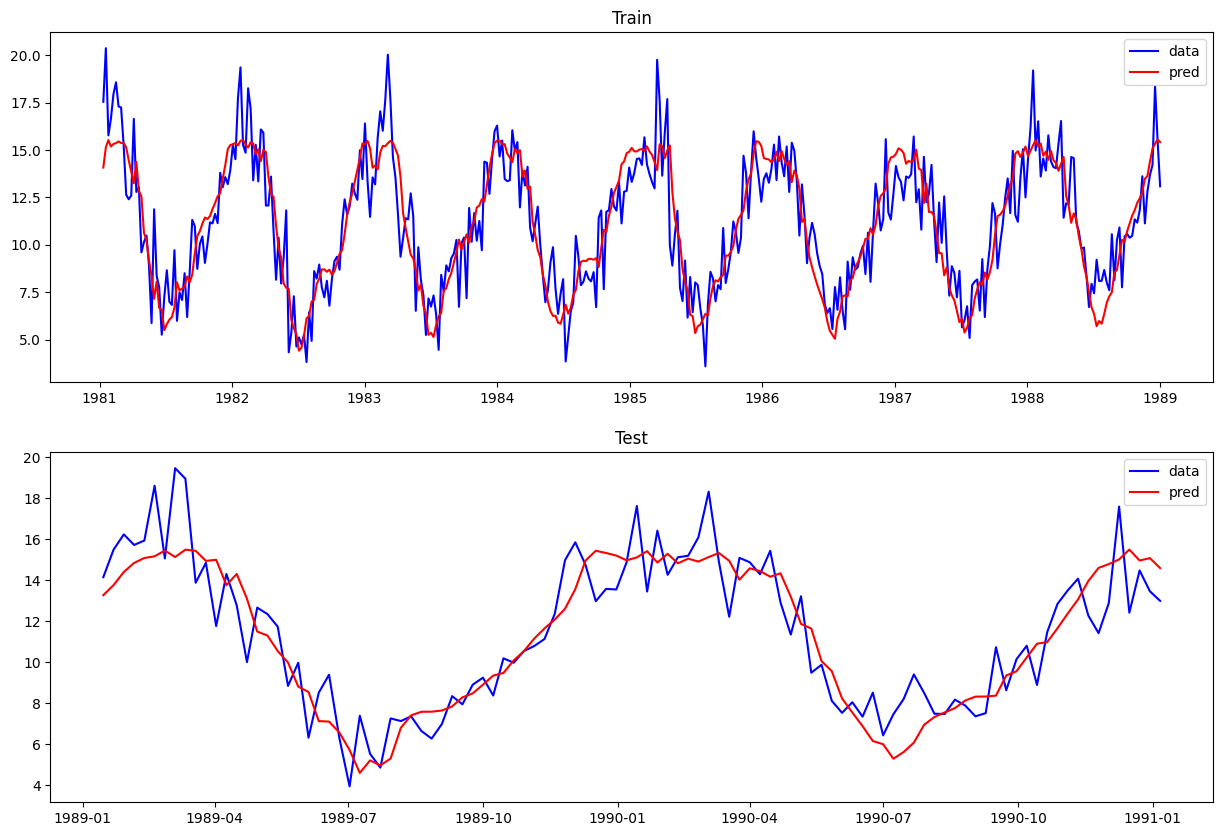

In [19]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

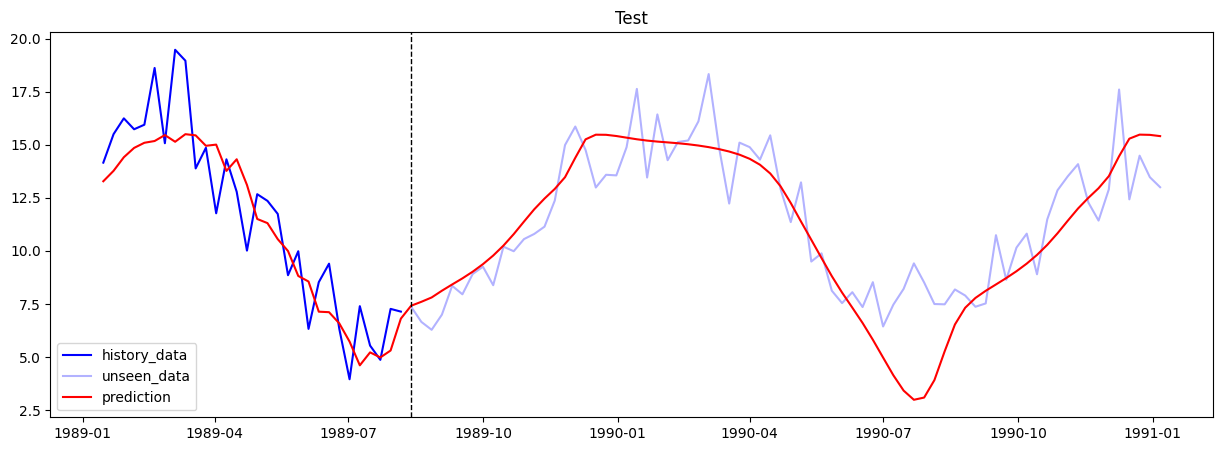

In [22]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior = 30, n_forecast = 100)
plt.title('Test')